In [ ]:
# Import the PyTorch library
import torch

# Import the neural network module in PyTorch
import torch.nn as nn

# Import the optimization module in PyTorch
import torch.optim as optim

# Import the torchvision library for computer vision tasks
import torchvision

# Import transforms module from torchvision for data transformations
import torchvision.transforms as transforms

# Import the matplotlib library for data visualization
import matplotlib.pyplot as plt

# Import the NumPy library for numerical operations
import numpy as np


In [ ]:
# Check if a GPU is available and use it, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

# Define a custom CNN class named "Net" that inherits from nn.Module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # Second convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Max-pooling layer
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)  # First fully-connected layer
        self.fc2 = nn.Linear(1024, 10)  # Second fully-connected layer (output layer)
        self.dropout = nn.Dropout(0.5)  # Dropout layer

    def forward(self, x):
        # Forward pass through the network

        # Apply the first convolutional layer, followed by ReLU activation, and then max-pooling
        x = self.pool(torch.relu(self.conv1(x)))

        # Apply the second convolutional layer, followed by ReLU activation, and then max-pooling
        x = self.pool(torch.relu(self.conv2(x)))

        # Flatten the output of the second convolutional layer
        x = x.view(-1, 64 * 7 * 7)

        # Apply dropout to reduce overfitting, followed by the first fully-connected layer and ReLU activation
        x = self.dropout(torch.relu(self.fc1(x)))

        # Apply the second fully-connected layer (output layer) to get class scores
        x = self.fc2(x)

        return x

# Create an instance of the CNN model
net = Net()

# Move the model to the GPU if available (device selection)
net = net.to(device)



In [ ]:


# Define a sequence of data transformations using the transforms.Compose() function.
# The transformations include converting images to tensors and normalizing pixel values.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Create a training dataset (trainset) using the MNIST dataset from torchvision.
trainset = torchvision.datasets.MNIST(
    root='./data',       # The directory where the dataset will be stored or retrieved.
    train=True,          # Indicates that this is the training dataset.
    download=True,       # Downloads the dataset if it's not already available locally.
    transform=transform  # Applies the defined transformations to the dataset.
)

# Create a data loader (trainloader) for the training dataset.
trainloader = torch.utils.data.DataLoader(
    trainset,            # The dataset to load.
    batch_size=64,       # The number of samples to load in each batch.
    shuffle=True,        # Shuffles the dataset at the beginning of each epoch.
    num_workers=2        # Number of CPU threads to use for data loading (can adjust for performance).
)

# Create a test dataset (testset) using the MNIST dataset from torchvision.
testset = torchvision.datasets.MNIST(
    root='./data',       # The directory where the dataset will be stored or retrieved.
    train=False,         # Indicates that this is the test dataset.
    download=True,       # Downloads the dataset if it's not already available locally.
    transform=transform  # Applies the same transformations to the test dataset as for training.
)

# Create a data loader (testloader) for the test dataset.
testloader = torch.utils.data.DataLoader(
    testset,             # The test dataset to load.
    batch_size=64,       # The number of samples to load in each batch for testing.
    shuffle=False,       # No need to shuffle the test dataset as it's used for evaluation.
    num_workers=2        # Number of CPU threads to use for data loading (can adjust for performance).
)




In [ ]:

# Define the loss function (criterion) to compute the loss during training.
# In this case, CrossEntropyLoss is used for classification tasks.
criterion = nn.CrossEntropyLoss().to(device)  # Move the loss function to the GPU if available

# Define the optimizer responsible for updating the model's parameters during training.
# Here, the Adam optimizer is used, and it optimizes the parameters of the "net" model.
# - net.parameters(): It specifies the model's parameters to be optimized.
# - lr=0.001: The learning rate determines the step size for parameter updates.
optimizer = optim.Adam(net.parameters(), lr=0.001)




In [ ]:
# Specify the number of training epochs
num_epochs = 10

# Initialize lists to store training and testing history
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

# Loop over the specified number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Set the model in training mode (enables dropout, batch normalization, etc.)
    net.train()

    # Iterate through the training data loader
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Move both inputs and labels to the GPU (if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients to prevent accumulation
        optimizer.zero_grad()

        # Forward pass through the model
        outputs = net(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backpropagation: Compute gradients and update model weights
        loss.backward()
        optimizer.step()

        # Calculate the running loss
        running_loss += loss.item()

        # Calculate the number of correctly predicted samples and total samples
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and store the average training loss and accuracy for this epoch
    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)

    # Set the model in evaluation mode (disables dropout)
    net.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0

    # Disable gradient computation for inference (no need to compute gradients for testing)
    with torch.no_grad():
        # Iterate through the test data loader
        for data in testloader:
            inputs, labels = data

            # Move both inputs and labels to the GPU (if available)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass through the model
            outputs = net(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Calculate the running loss
            running_loss += loss.item()

            # Calculate the number of correctly predicted samples and total samples
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculate and store the average testing loss and accuracy for this epoch
    test_loss = running_loss / len(testloader)
    test_accuracy = 100 * correct_test / total_test
    test_loss_history.append(test_loss)
    test_acc_history.append(test_accuracy)

    # Print training and testing statistics for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}] - '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')



Epoch [1/10] - Train Loss: 0.1426, Train Accuracy: 95.52%, Test Loss: 0.0412, Test Accuracy: 98.73%
Epoch [2/10] - Train Loss: 0.0478, Train Accuracy: 98.57%, Test Loss: 0.0370, Test Accuracy: 98.82%
Epoch [3/10] - Train Loss: 0.0346, Train Accuracy: 98.94%, Test Loss: 0.0228, Test Accuracy: 99.25%
Epoch [4/10] - Train Loss: 0.0244, Train Accuracy: 99.24%, Test Loss: 0.0249, Test Accuracy: 99.22%
Epoch [5/10] - Train Loss: 0.0220, Train Accuracy: 99.27%, Test Loss: 0.0244, Test Accuracy: 99.22%
Epoch [6/10] - Train Loss: 0.0164, Train Accuracy: 99.49%, Test Loss: 0.0305, Test Accuracy: 99.23%
Epoch [7/10] - Train Loss: 0.0157, Train Accuracy: 99.47%, Test Loss: 0.0224, Test Accuracy: 99.30%
Epoch [8/10] - Train Loss: 0.0137, Train Accuracy: 99.57%, Test Loss: 0.0299, Test Accuracy: 99.18%
Epoch [9/10] - Train Loss: 0.0099, Train Accuracy: 99.69%, Test Loss: 0.0325, Test Accuracy: 99.15%
Epoch [10/10] - Train Loss: 0.0113, Train Accuracy: 99.63%, Test Loss: 0.0309, Test Accuracy: 99.26%

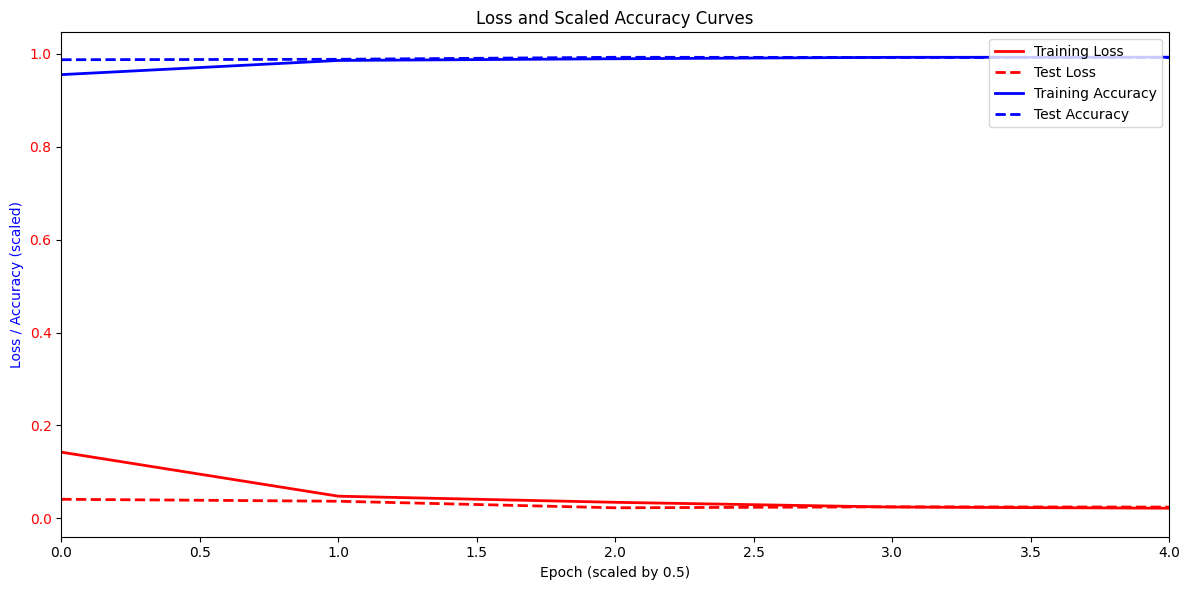

In [ ]:

# Scale down accuracy values by dividing by 100
scaled_train_acc_history = [acc / 100 for acc in train_acc_history]
scaled_test_acc_history = [acc / 100 for acc in test_acc_history]

# Create a single figure for both loss and accuracy curves
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Training Loss and Testing Loss on the first y-axis
ax1.set_xlabel('Epoch (scaled by 0.5)')
ax1.set_ylabel('Loss', color='red')
ax1.plot(train_loss_history, label='Training Loss', color='red', linewidth=2)
ax1.plot(test_loss_history, label='Test Loss', linestyle='dashed', color='red', linewidth=2)
ax1.tick_params(axis='y', labelcolor='red')
ax1.legend(loc='upper left')

# Plot scaled Training Accuracy and scaled Testing Accuracy on the same y-axis
ax1.plot(scaled_train_acc_history, label='Training Accuracy', color='blue', linewidth=2)
ax1.plot(scaled_test_acc_history, label='Test Accuracy', linestyle='dashed', color='blue', linewidth=2)
ax1.set_ylabel('Loss / Accuracy (scaled)', color='blue')
ax1.legend(loc='upper right')

plt.title('Loss and Scaled Accuracy Curves')  # Set the title for this subplot

# Set the x-axis limits to end at epoch 4.0
plt.xlim(0, 4.0)

plt.xticks([i * 0.5 for i in range(int(4.0 / 0.5) + 1)])  # Set x-axis ticks with 0.5 intervals
plt.tight_layout()  # Ensure proper spacing
plt.show()  # Display the entire figure










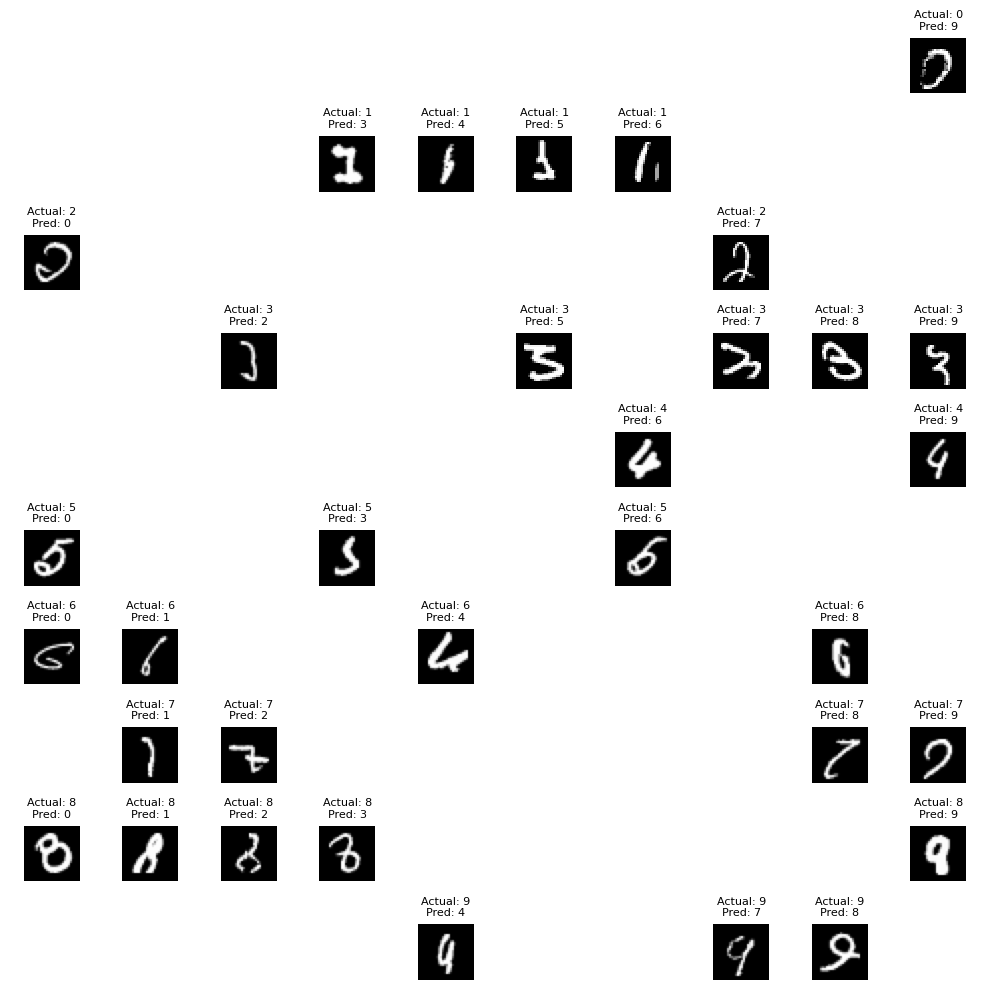

In [ ]:

# Create a 10x10 grid for the big figure
big_figure = np.empty((10, 10), dtype=object)

# Initialize the grid with None values
for i in range(10):
    for j in range(10):
        big_figure[i, j] = None

# Iterate through the misclassified samples and populate the grid
for image, predicted, actual in misclassified:
    if big_figure[actual][predicted] is None:
        big_figure[actual][predicted] = image.squeeze().cpu().numpy()

# Create a new figure for the big figure
plt.figure(figsize=(10, 10))

# Iterate through the grid and display images
for i in range(10):
    for j in range(10):
        if big_figure[i][j] is not None:
            plt.subplot(10, 10, i * 10 + j + 1)
            plt.imshow(big_figure[i][j], cmap='gray')
            plt.title(f'Actual: {i}\nPred: {j}', fontsize=8)
            plt.axis('off')
        else:
            plt.subplot(10, 10, i * 10 + j + 1)
            plt.axis('off')

# Adjust spacing between subplots for better visualization
plt.tight_layout()

# Show the big figure
plt.show()


